In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov 10 11:40:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [ ]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
from torch.utils.data import TensorDataset

In [ ]:
def clean_text(text):
    if isinstance(text, (str, np.ndarray)): 
        if isinstance(text, str):
            text = text.lower()
            text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
            return text
        elif isinstance(text, np.ndarray):
            return np.array([clean_text(t) for t in text])
    elif pd.isnull(text): 
        return ""
    else:
    
        try:
            text = str(text)
            text = text.lower()
            text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
            return text
        except Exception as e:
            print(f"Error cleaning text: {e}, Text Type: {type(text)}, Text Value: {text}")
            return "" 

In [ ]:
labeled_data = pd.read_csv("/content/drive/MyDrive/WoS/data/WoSDataset_18933.csv")

for col in ['Keywords', 'Abstract']:
    labeled_data[col] = labeled_data[col].apply(clean_text)

labeled_data['combined_text'] = labeled_data['Keywords'] + " [SEP] " + labeled_data['Abstract']

In [ ]:
abstractslbl = labeled_data['Abstract']
keywordsslbl = labeled_data['Keywords']
domainlbl = labeled_data['Domain']
lbls = labeled_data['Label']

In [ ]:
print(np.shape(labeled_data))
print(labeled_data.columns)

(18932, 5)
Index(['Label', 'Domain', 'Keywords', 'Abstract', 'combined_text'], dtype='object')


In [ ]:
labels = np.unique(domainlbl, return_counts=True)[0]
labelCounts=  np.unique(domainlbl, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [2758 2870 1952 3100 2634 2906 2712]


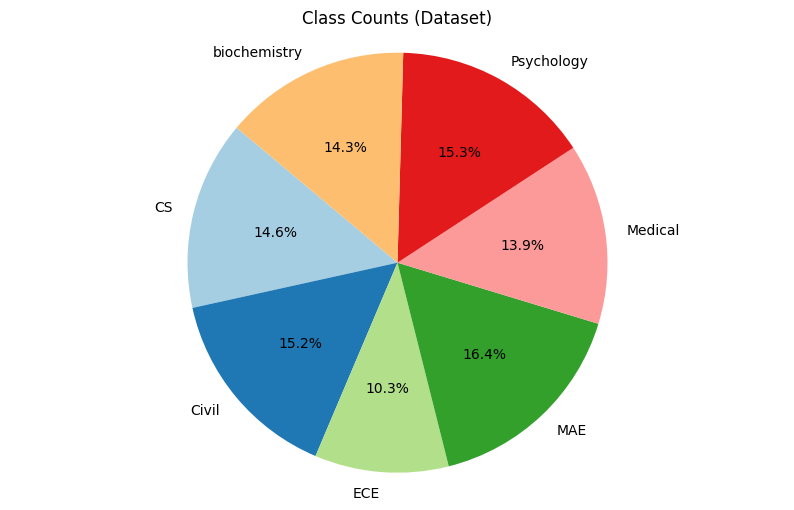

The label CS has 2758 records in the dataset.
The label Civil has 2870 records in the dataset.
The label ECE has 1952 records in the dataset.
The label MAE has 3100 records in the dataset.
The label Medical has 2634 records in the dataset.
The label Psychology has 2906 records in the dataset.
The label biochemistry has 2712 records in the dataset.


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [ ]:
labeled_data_shuffled = sklearn.utils.shuffle(labeled_data)
abstracts_shuffled = labeled_data_shuffled['Abstract'].values
keywords_shuffled = labeled_data_shuffled['Keywords'].values
domains_shuffled = labeled_data_shuffled['Domain'].values
allLabels_shuffled = labeled_data_shuffled['Label'].values
allLabels_digit_shuffled = allLabels_shuffled.astype(int)

In [ ]:
print(np.shape(labeled_data_shuffled))
print(np.shape(abstracts_shuffled))
print(np.shape(keywords_shuffled))
print(np.shape(domains_shuffled))

print(labeled_data_shuffled['combined_text'][0])

(18932, 5)
(18932,)
(18932,)
(18932,)
 interview anxiety interview performance person perception job interview         [SEP] the aim of this study was to investigate a the behavioral cues that are displayed by and trait judgments formed about anxious interviewees and b why anxious interviewees receive lower interview performance ratings the behavioral expression of interview anxiety model was created as a conceptual framework to explore these relations we videotaped and transcribed mock job interviews obtained ratings of interview anxiety and interview performance and trained raters to assess several verbal and nonverbal cues and trait judgments the results indicated that few behavioral cues but several traits were related to interviewee and interviewer ratings of interview anxiety two factors emerged from our factor analysis on the trait judgmentsassertiveness and interpersonal warmth mediation analyses were performed and indicated that assertiveness and interpersonal warmth mediated 

In [ ]:
train_data, test_data = train_test_split(labeled_data_shuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

_, val_data = train_test_split(test_data, test_size=0.5, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))



(15145, 5)
(3787, 5)
(15145, 5)
(3787, 5)
(1894, 5)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
abstractslbltrain = train_data['Abstract']
keywordsslbltrain = train_data['Keywords']
domainlbltrain = train_data['Domain']
lblstrain = train_data['Label']

In [ ]:
print(np.shape(labeled_data))
print(labeled_data.columns)

(18932, 5)
Index(['Label', 'Domain', 'Keywords', 'Abstract', 'combined_text'], dtype='object')


In [ ]:
labels = np.unique(domainlbltrain, return_counts=True)[0]
labelCounts=  np.unique(domainlbltrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [2209 2281 1565 2497 2090 2322 2181]


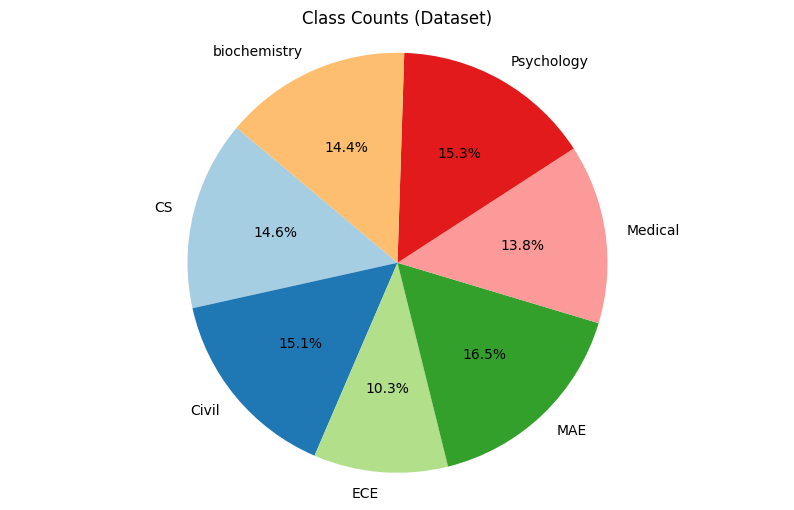

The label CS has 2209 records in the dataset.
The label Civil has 2281 records in the dataset.
The label ECE has 1565 records in the dataset.
The label MAE has 2497 records in the dataset.
The label Medical has 2090 records in the dataset.
The label Psychology has 2322 records in the dataset.
The label biochemistry has 2181 records in the dataset.


In [ ]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [ ]:
abstractslbltest = test_data['Abstract']
keywordsslbltest = test_data['Keywords']
domainlbltest = test_data['Domain']
lblstest = test_data['Label']

In [ ]:
labels = np.unique(domainlbltest, return_counts=True)[0]
labelCounts=  np.unique(domainlbltest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [549 589 387 603 544 584 531]


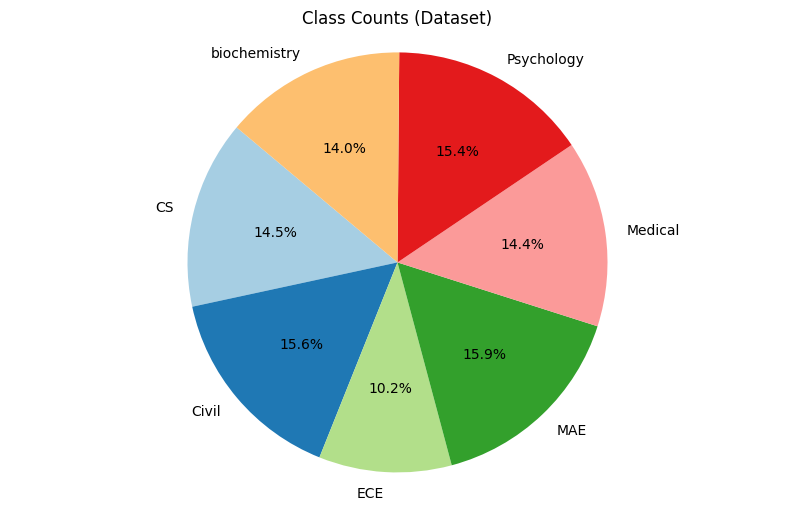

The label CS has 549 records in the dataset.
The label Civil has 589 records in the dataset.
The label ECE has 387 records in the dataset.
The label MAE has 603 records in the dataset.
The label Medical has 544 records in the dataset.
The label Psychology has 584 records in the dataset.
The label biochemistry has 531 records in the dataset.


In [ ]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [ ]:
abstractslblval = val_data['Abstract']
keywordsslblval = val_data['Keywords']
domainlblval = val_data['Domain']
lblsval = val_data['Label']

In [ ]:
labels = np.unique(domainlblval, return_counts=True)[0]
labelCounts=  np.unique(domainlblval, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [272 303 192 290 268 307 262]


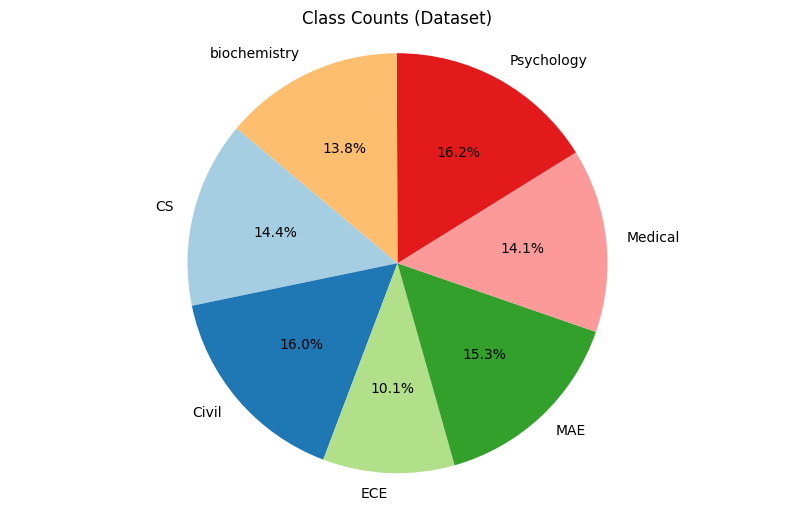

The label CS has 272 records in the dataset.
The label Civil has 303 records in the dataset.
The label ECE has 192 records in the dataset.
The label MAE has 290 records in the dataset.
The label Medical has 268 records in the dataset.
The label Psychology has 307 records in the dataset.
The label biochemistry has 262 records in the dataset.


In [ ]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [ ]:
def encode_data(data, tokenizer, max_length=128, labeled=True):
    inputs = tokenizer(
        data['combined_text'].tolist(),
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    if labeled and 'Label' in data.columns:
        labels = torch.tensor(data['Label'].values.astype(int))
        return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
    else:
        return TensorDataset(inputs['input_ids'], inputs['attention_mask'])


In [ ]:
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)

In [ ]:
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

In [ ]:
print(len(np.unique(train_data['Label'])))
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2", num_labels=len(np.unique(train_data['Label'])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

7


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def calculate_metrics_f(valType, predictions, true_labels):
    if valType == 'test':
        cm = confusion_matrix(true_labels, predictions)
        report = classification_report(true_labels, predictions)
        f1_micro = f1_score(true_labels, predictions, average='micro')
        print("\nClassification Report:\n", report)
        return f1_micro
    elif valType == 'val':
        f1_micro = f1_score(true_labels, predictions, average='micro')
        return f1_micro

In [ ]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [ ]:

epochs = 20
learning_rates = [2e-5, 5e-6, 1e-6, 2e-6]
early_stopping_patience = 5
best_val_f1 = 0
early_stopping_counter = 0

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * total_steps, num_training_steps=total_steps)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, labels = batch
            model.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f"Train Loss: {avg_train_loss}")

        # Validation
        model.eval()
        predictions, true_labels = [], []
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, labels = batch
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits.detach().cpu().numpy()
            batch_predictions = np.argmax(logits, axis=1)
            predictions.extend(batch_predictions)
            true_labels.extend(labels.to('cpu').numpy())
        val_f1 = f1_score(true_labels, predictions, average='micro')
        print(f"Validation Micro F1: {val_f1}")
        val_micro_f1 = calculate_metrics_f('val', predictions, true_labels)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss}, Val Micro F1: {val_micro_f1}")

        # Early stopping check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            early_stopping_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print("Best model saved.")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping applied.")
                break

# Load the best model for testing
model.load_state_dict(torch.load('best_model.pth'))
print("Best model loaded.")


Training with learning rate: 2e-05


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 1.2004954907650183
Validation Micro F1: 0.8875395987328405
Epoch 1/20, Train Loss: 1.2004954907650183, Val Micro F1: 0.8875395987328405
Best model saved.


Epoch 2/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.3350068432699402
Validation Micro F1: 0.912882787750792
Epoch 2/20, Train Loss: 0.3350068432699402, Val Micro F1: 0.912882787750792
Best model saved.


Epoch 3/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.22312614005766337
Validation Micro F1: 0.909714889123548
Epoch 3/20, Train Loss: 0.22312614005766337, Val Micro F1: 0.909714889123548


Epoch 4/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.1475781198995746
Validation Micro F1: 0.9118268215417107
Epoch 4/20, Train Loss: 0.1475781198995746, Val Micro F1: 0.9118268215417107


Epoch 5/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.08859345955255477
Validation Micro F1: 0.9165786694825766
Epoch 5/20, Train Loss: 0.08859345955255477, Val Micro F1: 0.9165786694825766
Best model saved.


Epoch 6/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.05929921826108001
Validation Micro F1: 0.9118268215417107
Epoch 6/20, Train Loss: 0.05929921826108001, Val Micro F1: 0.9118268215417107


Epoch 7/20: 100%|██████████| 474/474 [04:55<00:00,  1.60batch/s]


Train Loss: 0.03551166927965578
Validation Micro F1: 0.9160506863780359
Epoch 7/20, Train Loss: 0.03551166927965578, Val Micro F1: 0.9160506863780359


Epoch 8/20: 100%|██████████| 474/474 [04:55<00:00,  1.60batch/s]


Train Loss: 0.024148442747094965
Validation Micro F1: 0.9155227032734953
Epoch 8/20, Train Loss: 0.024148442747094965, Val Micro F1: 0.9155227032734953


Epoch 9/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.01742880939572798
Validation Micro F1: 0.9234424498416051
Epoch 9/20, Train Loss: 0.01742880939572798, Val Micro F1: 0.9234424498416051
Best model saved.


Epoch 10/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.008756554697076337
Validation Micro F1: 0.914466737064414
Epoch 10/20, Train Loss: 0.008756554697076337, Val Micro F1: 0.914466737064414


Epoch 11/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.009077018393814675
Validation Micro F1: 0.9171066525871172
Epoch 11/20, Train Loss: 0.009077018393814675, Val Micro F1: 0.9171066525871172


Epoch 12/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.01369237538782255
Validation Micro F1: 0.9118268215417107
Epoch 12/20, Train Loss: 0.01369237538782255, Val Micro F1: 0.9118268215417107


Epoch 13/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.008290786296927434
Validation Micro F1: 0.9176346356916578
Epoch 13/20, Train Loss: 0.008290786296927434, Val Micro F1: 0.9176346356916578


Epoch 14/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.004069030040507657
Validation Micro F1: 0.925026399155227
Epoch 14/20, Train Loss: 0.004069030040507657, Val Micro F1: 0.925026399155227
Best model saved.


Epoch 15/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.0034157844906390882
Validation Micro F1: 0.9244984160506864
Epoch 15/20, Train Loss: 0.0034157844906390882, Val Micro F1: 0.9244984160506864


Epoch 16/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.0029628582100800476
Validation Micro F1: 0.925026399155227
Epoch 16/20, Train Loss: 0.0029628582100800476, Val Micro F1: 0.925026399155227


Epoch 17/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.001681575377435887
Validation Micro F1: 0.9244984160506864
Epoch 17/20, Train Loss: 0.001681575377435887, Val Micro F1: 0.9244984160506864


Epoch 18/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.0017094200947086174
Validation Micro F1: 0.9287222808870116
Epoch 18/20, Train Loss: 0.0017094200947086174, Val Micro F1: 0.9287222808870116
Best model saved.


Epoch 19/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.0016726447229839976
Validation Micro F1: 0.9287222808870116
Epoch 19/20, Train Loss: 0.0016726447229839976, Val Micro F1: 0.9287222808870116


Epoch 20/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.0009700213225567242


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Micro F1: 0.9271383315733897
Epoch 20/20, Train Loss: 0.0009700213225567242, Val Micro F1: 0.9271383315733897

Training with learning rate: 5e-06


Epoch 1/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.0008994660720993954
Validation Micro F1: 0.925026399155227
Epoch 1/20, Train Loss: 0.0008994660720993954, Val Micro F1: 0.925026399155227


Epoch 2/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.0031285180222367834
Validation Micro F1: 0.9223864836325237
Epoch 2/20, Train Loss: 0.0031285180222367834, Val Micro F1: 0.9223864836325237


Epoch 3/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.0026586899563155867


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Micro F1: 0.925026399155227
Epoch 3/20, Train Loss: 0.0026586899563155867, Val Micro F1: 0.925026399155227
Early stopping applied.

Training with learning rate: 1e-06


Epoch 1/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.0008215332968479302


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Micro F1: 0.9239704329461457
Epoch 1/20, Train Loss: 0.0008215332968479302, Val Micro F1: 0.9239704329461457
Early stopping applied.

Training with learning rate: 2e-06


Epoch 1/20: 100%|██████████| 474/474 [04:56<00:00,  1.60batch/s]


Train Loss: 0.0008381861560736814
Validation Micro F1: 0.9213305174234424
Epoch 1/20, Train Loss: 0.0008381861560736814, Val Micro F1: 0.9213305174234424
Early stopping applied.


<ipython-input-31-99034260d263>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Best model loaded.


In [ ]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[515  10   5  11   7   0   1]
 [  7 361   0  11   7   0   1]
 [  3   1 543   2   6  28   1]
 [  6  21   0 565  10   1   0]
 [  8   4   1  11 562   0   3]
 [  1   3  52   3   2 463  20]
 [  5   2   0   1   8  22 493]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       549
           1       0.90      0.93      0.92       387
           2       0.90      0.93      0.92       584
           3       0.94      0.94      0.94       603
           4       0.93      0.95      0.94       589
           5       0.90      0.85      0.88       544
           6       0.95      0.93      0.94       531

    accuracy                           0.92      3787
   macro avg       0.92      0.92      0.92      3787
weighted avg       0.92      0.92      0.92      3787

Macro F1 Score: 0.9238958998920154
Micro F1 Score: 0.9247425402693424
Weighted F1 Score: 0.9245815667803192
Macro Precision: 0.92373220098811

In [ ]:
print("\nTest Metrics:")
print("Confusion Matrix:\n", confusion_matrix(true_labels, predictions))
print("Classification Report:\n", classification_report(true_labels, predictions))
print("Macro F1:", f1_score(true_labels, predictions, average='macro'))
print("Micro F1:", f1_score(true_labels, predictions, average='micro'))
print("Weighted F1:", f1_score(true_labels, predictions, average='weighted'))


Test Metrics:
Confusion Matrix:
 [[515  10   5  11   7   0   1]
 [  7 361   0  11   7   0   1]
 [  3   1 543   2   6  28   1]
 [  6  21   0 565  10   1   0]
 [  8   4   1  11 562   0   3]
 [  1   3  52   3   2 463  20]
 [  5   2   0   1   8  22 493]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       549
           1       0.90      0.93      0.92       387
           2       0.90      0.93      0.92       584
           3       0.94      0.94      0.94       603
           4       0.93      0.95      0.94       589
           5       0.90      0.85      0.88       544
           6       0.95      0.93      0.94       531

    accuracy                           0.92      3787
   macro avg       0.92      0.92      0.92      3787
weighted avg       0.92      0.92      0.92      3787

Macro F1: 0.9238958998920154
Micro F1: 0.9247425402693424
Weighted F1: 0.9245815667803192


In [ ]:
model.save_pretrained('/content/drive/MyDrive/WoS/BioBERT_WoS_18933_records')

In [ ]:
from google.colab import runtime
print('End of the runtime!')
runtime.unassign()

End of the runtime!
